In [1]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
set_config(transform_output="pandas") 

In [3]:
# load the data

data = fetch_california_housing(as_frame=True)

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
# make X and y

X, y = data.data, data.target

In [6]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [9]:
X.shape

(20640, 8)

In [10]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


## Model

In [11]:
# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [12]:
# fit the training data
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [13]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


### HP Tuning

In [14]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [15]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-09-08 17:16:19,582] A new study created in memory with name: no-name-4045703e-8924-4701-a2f3-8a229a42cbe5
Best trial: 1. Best value: 0.81798:   4%|▍         | 2/50 [00:02<00:53,  1.12s/it] 

[I 2025-09-08 17:16:22,118] Trial 2 finished with value: 0.8145237431045114 and parameters: {'learning_rate': 0.072263273492653, 'n_estimators': 161, 'max_depth': 8, 'reg_lambda': 94.72752111111318, 'gamma': 1.7374712824893601, 'subsample': 0.7008799639401294}. Best is trial 2 with value: 0.8145237431045114.
[I 2025-09-08 17:16:22,309] Trial 1 finished with value: 0.817979708832998 and parameters: {'learning_rate': 0.05640478361094622, 'n_estimators': 119, 'max_depth': 10, 'reg_lambda': 54.50056600182467, 'gamma': 1.9744033430778285, 'subsample': 0.9058708760968391}. Best is trial 1 with value: 0.817979708832998.


Best trial: 3. Best value: 0.833552:   6%|▌         | 3/50 [00:03<00:40,  1.16it/s]

[I 2025-09-08 17:16:22,866] Trial 3 finished with value: 0.8335516127913778 and parameters: {'learning_rate': 0.13880760375910692, 'n_estimators': 378, 'max_depth': 5, 'reg_lambda': 26.110666580665654, 'gamma': 0.7335654418727227, 'subsample': 0.8923233984833068}. Best is trial 3 with value: 0.8335516127913778.


Best trial: 3. Best value: 0.833552:   8%|▊         | 4/50 [00:04<00:43,  1.05it/s]

[I 2025-09-08 17:16:23,961] Trial 4 finished with value: 0.8076059900560195 and parameters: {'learning_rate': 0.22160540620657207, 'n_estimators': 162, 'max_depth': 4, 'reg_lambda': 23.448715067368795, 'gamma': 1.9422084798580017, 'subsample': 0.7555827880863384}. Best is trial 3 with value: 0.8335516127913778.


Best trial: 3. Best value: 0.833552:  10%|█         | 5/50 [00:05<00:49,  1.09s/it]

[I 2025-09-08 17:16:25,290] Trial 7 finished with value: 0.8225298030891492 and parameters: {'learning_rate': 0.1308572522227432, 'n_estimators': 73, 'max_depth': 8, 'reg_lambda': 72.47885972054004, 'gamma': 1.067622211554985, 'subsample': 0.8970264214634074}. Best is trial 3 with value: 0.8335516127913778.


Best trial: 3. Best value: 0.833552:  12%|█▏        | 6/50 [00:06<00:44,  1.02s/it]

[I 2025-09-08 17:16:26,172] Trial 5 finished with value: 0.8208878197618492 and parameters: {'learning_rate': 0.07918866759201824, 'n_estimators': 421, 'max_depth': 5, 'reg_lambda': 9.217857370215365, 'gamma': 1.8086647634998771, 'subsample': 0.7507417804884613}. Best is trial 3 with value: 0.8335516127913778.


Best trial: 3. Best value: 0.833552:  14%|█▍        | 7/50 [00:06<00:34,  1.23it/s]

[I 2025-09-08 17:16:26,552] Trial 0 finished with value: 0.8190996525779135 and parameters: {'learning_rate': 0.028875736114412236, 'n_estimators': 434, 'max_depth': 9, 'reg_lambda': 62.690748702164576, 'gamma': 1.8013406930176723, 'subsample': 0.8354001047676868}. Best is trial 3 with value: 0.8335516127913778.


Best trial: 6. Best value: 0.847428:  16%|█▌        | 8/50 [00:07<00:33,  1.24it/s]

[I 2025-09-08 17:16:27,347] Trial 6 finished with value: 0.8474276918593003 and parameters: {'learning_rate': 0.19377607295317942, 'n_estimators': 108, 'max_depth': 10, 'reg_lambda': 37.97438303852271, 'gamma': 0.0034652586831156462, 'subsample': 0.8729058516073538}. Best is trial 6 with value: 0.8474276918593003.


Best trial: 6. Best value: 0.847428:  18%|█▊        | 9/50 [00:08<00:34,  1.20it/s]

[I 2025-09-08 17:16:28,249] Trial 10 finished with value: 0.8293000249116036 and parameters: {'learning_rate': 0.23497067848792258, 'n_estimators': 144, 'max_depth': 8, 'reg_lambda': 85.3030064930809, 'gamma': 0.8756187442789316, 'subsample': 0.9223761521362601}. Best is trial 6 with value: 0.8474276918593003.
[I 2025-09-08 17:16:28,344] Trial 11 finished with value: 0.8063331895929792 and parameters: {'learning_rate': 0.24857551817499418, 'n_estimators': 125, 'max_depth': 3, 'reg_lambda': 49.34305403938835, 'gamma': 1.3356335272451587, 'subsample': 0.8864033752082507}. Best is trial 6 with value: 0.8474276918593003.


Best trial: 6. Best value: 0.847428:  22%|██▏       | 11/50 [00:09<00:26,  1.45it/s]

[I 2025-09-08 17:16:29,300] Trial 9 finished with value: 0.8165410837876357 and parameters: {'learning_rate': 0.22340401831252055, 'n_estimators': 457, 'max_depth': 7, 'reg_lambda': 18.019930936657133, 'gamma': 1.2205841227895056, 'subsample': 0.9732833967829133}. Best is trial 6 with value: 0.8474276918593003.


Best trial: 6. Best value: 0.847428:  26%|██▌       | 13/50 [00:10<00:21,  1.70it/s]

[I 2025-09-08 17:16:30,217] Trial 8 finished with value: 0.8403600610306431 and parameters: {'learning_rate': 0.11455261214111846, 'n_estimators': 366, 'max_depth': 10, 'reg_lambda': 12.870992529680136, 'gamma': 0.5162474417707801, 'subsample': 0.8133028062304559}. Best is trial 6 with value: 0.8474276918593003.
[I 2025-09-08 17:16:30,365] Trial 12 finished with value: 0.8201732943344878 and parameters: {'learning_rate': 0.24981184467690226, 'n_estimators': 254, 'max_depth': 8, 'reg_lambda': 6.23902358669593, 'gamma': 1.198217195570995, 'subsample': 0.9220130309166832}. Best is trial 6 with value: 0.8474276918593003.


Best trial: 6. Best value: 0.847428:  28%|██▊       | 14/50 [00:14<00:48,  1.35s/it]

[I 2025-09-08 17:16:33,747] Trial 13 finished with value: 0.8457985004522068 and parameters: {'learning_rate': 0.29025272100680555, 'n_estimators': 272, 'max_depth': 10, 'reg_lambda': 40.79452624634189, 'gamma': 0.022046605837154565, 'subsample': 0.9958510139601868}. Best is trial 6 with value: 0.8474276918593003.


Best trial: 14. Best value: 0.849356:  30%|███       | 15/50 [00:15<00:47,  1.37s/it]

[I 2025-09-08 17:16:35,160] Trial 14 finished with value: 0.8493557115636452 and parameters: {'learning_rate': 0.1588597965525151, 'n_estimators': 295, 'max_depth': 6, 'reg_lambda': 35.599562493759024, 'gamma': 0.12894015532972147, 'subsample': 0.8261675583117608}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  32%|███▏      | 16/50 [00:16<00:41,  1.23s/it]

[I 2025-09-08 17:16:36,052] Trial 15 finished with value: 0.8455908977652037 and parameters: {'learning_rate': 0.18015127047491078, 'n_estimators': 290, 'max_depth': 10, 'reg_lambda': 38.43762576652506, 'gamma': 0.16881992656914355, 'subsample': 0.82767137920458}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  34%|███▍      | 17/50 [00:16<00:34,  1.04s/it]

[I 2025-09-08 17:16:36,626] Trial 16 finished with value: 0.8471335925897481 and parameters: {'learning_rate': 0.1810790048358597, 'n_estimators': 288, 'max_depth': 10, 'reg_lambda': 37.39024257797807, 'gamma': 0.13177384748109192, 'subsample': 0.8272818576622007}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  36%|███▌      | 18/50 [00:17<00:30,  1.05it/s]

[I 2025-09-08 17:16:37,356] Trial 17 finished with value: 0.8415690703491887 and parameters: {'learning_rate': 0.298024156086741, 'n_estimators': 259, 'max_depth': 10, 'reg_lambda': 36.859684363351235, 'gamma': 0.07291393237970951, 'subsample': 0.985032559412779}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  38%|███▊      | 19/50 [00:19<00:34,  1.11s/it]

[I 2025-09-08 17:16:38,846] Trial 18 finished with value: 0.8473632183344318 and parameters: {'learning_rate': 0.1729714961388767, 'n_estimators': 224, 'max_depth': 6, 'reg_lambda': 37.20062128751851, 'gamma': 0.12951479733000457, 'subsample': 0.7947011598961625}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  40%|████      | 20/50 [00:19<00:27,  1.08it/s]

[I 2025-09-08 17:16:39,351] Trial 19 finished with value: 0.8452983350305379 and parameters: {'learning_rate': 0.18104035068448046, 'n_estimators': 226, 'max_depth': 6, 'reg_lambda': 35.143298470056024, 'gamma': 0.31810550157787426, 'subsample': 0.7753602266732008}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  42%|████▏     | 21/50 [00:19<00:21,  1.36it/s]

[I 2025-09-08 17:16:39,619] Trial 20 finished with value: 0.8418022939807333 and parameters: {'learning_rate': 0.17076943250268314, 'n_estimators': 231, 'max_depth': 6, 'reg_lambda': 30.05052622724691, 'gamma': 0.4373683232555555, 'subsample': 0.7787388340973128}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  44%|████▍     | 22/50 [00:20<00:20,  1.35it/s]

[I 2025-09-08 17:16:40,379] Trial 21 finished with value: 0.843042033109555 and parameters: {'learning_rate': 0.1849101966685753, 'n_estimators': 208, 'max_depth': 6, 'reg_lambda': 66.7336343555135, 'gamma': 0.42841820244445494, 'subsample': 0.7894544391416812}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  46%|████▌     | 23/50 [00:20<00:16,  1.66it/s]

[I 2025-09-08 17:16:40,657] Trial 23 finished with value: 0.8051332461715299 and parameters: {'learning_rate': 0.10565016294329377, 'n_estimators': 50, 'max_depth': 7, 'reg_lambda': 62.36512323718043, 'gamma': 0.4689069949023307, 'subsample': 0.8672114637508749}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  48%|████▊     | 24/50 [00:21<00:14,  1.83it/s]

[I 2025-09-08 17:16:41,068] Trial 24 finished with value: 0.828802678875025 and parameters: {'learning_rate': 0.1998487765566203, 'n_estimators': 63, 'max_depth': 7, 'reg_lambda': 47.11159680309286, 'gamma': 0.3287803253611919, 'subsample': 0.8640443107200391}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  50%|█████     | 25/50 [00:22<00:17,  1.40it/s]

[I 2025-09-08 17:16:42,177] Trial 22 finished with value: 0.8410134551628177 and parameters: {'learning_rate': 0.19186701494811714, 'n_estimators': 339, 'max_depth': 6, 'reg_lambda': 67.75407800354414, 'gamma': 0.48135091617669234, 'subsample': 0.8667624110996579}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  52%|█████▏    | 26/50 [00:23<00:21,  1.10it/s]

[I 2025-09-08 17:16:43,542] Trial 25 finished with value: 0.8384168917730517 and parameters: {'learning_rate': 0.10043369861291651, 'n_estimators': 332, 'max_depth': 7, 'reg_lambda': 47.84811264169273, 'gamma': 0.6590754189481082, 'subsample': 0.8497218758821097}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  54%|█████▍    | 27/50 [00:24<00:16,  1.36it/s]

[I 2025-09-08 17:16:43,865] Trial 27 finished with value: 0.8383689687309169 and parameters: {'learning_rate': 0.1420354917809639, 'n_estimators': 334, 'max_depth': 5, 'reg_lambda': 54.05669624958082, 'gamma': 0.6087953482322596, 'subsample': 0.8026040401948363}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  56%|█████▌    | 28/50 [00:24<00:13,  1.68it/s]

[I 2025-09-08 17:16:44,139] Trial 26 finished with value: 0.8462722351393538 and parameters: {'learning_rate': 0.14837682398531632, 'n_estimators': 328, 'max_depth': 5, 'reg_lambda': 52.76698463604027, 'gamma': 0.24444309501453798, 'subsample': 0.8526360272532699}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  58%|█████▊    | 29/50 [00:25<00:16,  1.26it/s]

[I 2025-09-08 17:16:45,400] Trial 28 finished with value: 0.8377470852164423 and parameters: {'learning_rate': 0.15292756471753194, 'n_estimators': 319, 'max_depth': 5, 'reg_lambda': 52.343259740646694, 'gamma': 0.6535434170397387, 'subsample': 0.8080925710600944}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  62%|██████▏   | 31/50 [00:26<00:12,  1.50it/s]

[I 2025-09-08 17:16:46,517] Trial 30 finished with value: 0.8307161564116329 and parameters: {'learning_rate': 0.1572049364164716, 'n_estimators': 200, 'max_depth': 4, 'reg_lambda': 23.125128120287478, 'gamma': 0.22218399093418204, 'subsample': 0.7439033944005732}. Best is trial 14 with value: 0.8493557115636452.
[I 2025-09-08 17:16:46,652] Trial 29 finished with value: 0.8409122896188378 and parameters: {'learning_rate': 0.14943295581892876, 'n_estimators': 198, 'max_depth': 5, 'reg_lambda': 56.62589105062368, 'gamma': 0.23791966708503615, 'subsample': 0.8066186255589428}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  64%|██████▍   | 32/50 [00:27<00:09,  1.84it/s]

[I 2025-09-08 17:16:46,912] Trial 31 finished with value: 0.8319521981799576 and parameters: {'learning_rate': 0.15932595785512105, 'n_estimators': 193, 'max_depth': 4, 'reg_lambda': 18.722052031981924, 'gamma': 0.03000755453216003, 'subsample': 0.7165396207120631}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  66%|██████▌   | 33/50 [00:31<00:29,  1.72s/it]

[I 2025-09-08 17:16:51,368] Trial 33 finished with value: 0.7906423768712689 and parameters: {'learning_rate': 0.02986955395918739, 'n_estimators': 100, 'max_depth': 9, 'reg_lambda': 29.623540783095045, 'gamma': 0.02449546887729627, 'subsample': 0.7172700393771395}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  68%|██████▊   | 34/50 [00:33<00:27,  1.74s/it]

[I 2025-09-08 17:16:53,171] Trial 32 finished with value: 0.8363142665158135 and parameters: {'learning_rate': 0.03425033044717031, 'n_estimators': 195, 'max_depth': 9, 'reg_lambda': 1.7158750285802213, 'gamma': 0.1993863107158259, 'subsample': 0.7210359841507794}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  70%|███████   | 35/50 [00:34<00:22,  1.48s/it]

[I 2025-09-08 17:16:54,032] Trial 35 finished with value: 0.8475651845257157 and parameters: {'learning_rate': 0.2106308443950143, 'n_estimators': 292, 'max_depth': 9, 'reg_lambda': 43.76049601515045, 'gamma': 0.13476901821148032, 'subsample': 0.8255692866374703}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  72%|███████▏  | 36/50 [00:37<00:28,  2.01s/it]

[I 2025-09-08 17:16:57,282] Trial 38 finished with value: 0.8226083555845333 and parameters: {'learning_rate': 0.217661707563708, 'n_estimators': 406, 'max_depth': 9, 'reg_lambda': 42.87284052363362, 'gamma': 1.5485745699071374, 'subsample': 0.8408897432551795}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  74%|███████▍  | 37/50 [00:38<00:20,  1.61s/it]

[I 2025-09-08 17:16:57,947] Trial 36 finished with value: 0.8468924340235331 and parameters: {'learning_rate': 0.20211635498633393, 'n_estimators': 292, 'max_depth': 9, 'reg_lambda': 43.12336020913845, 'gamma': 0.13050956780787928, 'subsample': 0.8381278822499447}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  76%|███████▌  | 38/50 [00:38<00:14,  1.20s/it]

[I 2025-09-08 17:16:58,204] Trial 34 finished with value: 0.8425784427780098 and parameters: {'learning_rate': 0.20683766864701447, 'n_estimators': 290, 'max_depth': 9, 'reg_lambda': 31.442185007053837, 'gamma': 0.010097774196584332, 'subsample': 0.8297674330683741}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  78%|███████▊  | 39/50 [00:39<00:13,  1.26s/it]

[I 2025-09-08 17:16:59,594] Trial 37 finished with value: 0.8477529573779721 and parameters: {'learning_rate': 0.2019552815344549, 'n_estimators': 306, 'max_depth': 9, 'reg_lambda': 44.2225948763261, 'gamma': 0.11780242283474458, 'subsample': 0.8348531289481256}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  80%|████████  | 40/50 [00:40<00:11,  1.15s/it]

[I 2025-09-08 17:17:00,501] Trial 41 finished with value: 0.8428645489717141 and parameters: {'learning_rate': 0.25457611359940446, 'n_estimators': 162, 'max_depth': 8, 'reg_lambda': 59.01216542082048, 'gamma': 0.2778718680102151, 'subsample': 0.8785560999484773}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  82%|████████▏ | 41/50 [00:41<00:08,  1.09it/s]

[I 2025-09-08 17:17:00,875] Trial 39 finished with value: 0.8328271005586192 and parameters: {'learning_rate': 0.20369109227751742, 'n_estimators': 499, 'max_depth': 9, 'reg_lambda': 31.222296250226904, 'gamma': 0.8550158229533437, 'subsample': 0.8309434688720715}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  84%|████████▍ | 42/50 [00:41<00:06,  1.20it/s]

[I 2025-09-08 17:17:01,507] Trial 40 finished with value: 0.8410631578730757 and parameters: {'learning_rate': 0.27193332411102894, 'n_estimators': 367, 'max_depth': 8, 'reg_lambda': 31.00008041219511, 'gamma': 0.3207610152063808, 'subsample': 0.8827393419912299}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  86%|████████▌ | 43/50 [00:43<00:07,  1.07s/it]

[I 2025-09-08 17:17:03,139] Trial 42 finished with value: 0.8341476442032733 and parameters: {'learning_rate': 0.25011431113375765, 'n_estimators': 497, 'max_depth': 8, 'reg_lambda': 75.87166946565038, 'gamma': 0.8287825453424663, 'subsample': 0.8834669044406445}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  88%|████████▊ | 44/50 [00:44<00:05,  1.05it/s]

[I 2025-09-08 17:17:03,800] Trial 43 finished with value: 0.8294523835514497 and parameters: {'learning_rate': 0.26795485832365235, 'n_estimators': 491, 'max_depth': 8, 'reg_lambda': 80.97886626276878, 'gamma': 0.7995406699880703, 'subsample': 0.9059181669528094}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  90%|█████████ | 45/50 [00:45<00:05,  1.08s/it]

[I 2025-09-08 17:17:05,200] Trial 45 finished with value: 0.8492117812476598 and parameters: {'learning_rate': 0.2335373253687147, 'n_estimators': 243, 'max_depth': 6, 'reg_lambda': 44.12999409335654, 'gamma': 0.11868483622174121, 'subsample': 0.9142771986343745}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 14. Best value: 0.849356:  92%|█████████▏| 46/50 [00:46<00:04,  1.11s/it]

[I 2025-09-08 17:17:06,382] Trial 46 finished with value: 0.8426848146223193 and parameters: {'learning_rate': 0.23301613831680829, 'n_estimators': 310, 'max_depth': 6, 'reg_lambda': 43.72199589337651, 'gamma': 0.3933886858098043, 'subsample': 0.792378347574314}. Best is trial 14 with value: 0.8493557115636452.


Best trial: 44. Best value: 0.851493:  94%|█████████▍| 47/50 [00:48<00:03,  1.32s/it]

[I 2025-09-08 17:17:08,193] Trial 44 finished with value: 0.851493149239371 and parameters: {'learning_rate': 0.12289075801863934, 'n_estimators': 380, 'max_depth': 6, 'reg_lambda': 43.1498914764542, 'gamma': 0.11948646490242118, 'subsample': 0.7820263169566318}. Best is trial 44 with value: 0.851493149239371.


Best trial: 44. Best value: 0.851493:  96%|█████████▌| 48/50 [00:48<00:02,  1.01s/it]

[I 2025-09-08 17:17:08,479] Trial 48 finished with value: 0.8412103623864483 and parameters: {'learning_rate': 0.22361441039283225, 'n_estimators': 314, 'max_depth': 7, 'reg_lambda': 44.78989655052262, 'gamma': 0.4121112959385249, 'subsample': 0.9158178688808754}. Best is trial 44 with value: 0.851493149239371.


Best trial: 44. Best value: 0.851493:  98%|█████████▊| 49/50 [00:49<00:00,  1.16it/s]

[I 2025-09-08 17:17:08,996] Trial 47 finished with value: 0.8486671463066606 and parameters: {'learning_rate': 0.22660709158890502, 'n_estimators': 313, 'max_depth': 6, 'reg_lambda': 24.31003411269449, 'gamma': 0.13380390576955536, 'subsample': 0.7911820675325303}. Best is trial 44 with value: 0.851493149239371.


Best trial: 44. Best value: 0.851493: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

[I 2025-09-08 17:17:11,059] Trial 49 finished with value: 0.8508209881659885 and parameters: {'learning_rate': 0.12527340189374234, 'n_estimators': 395, 'max_depth': 10, 'reg_lambda': 95.54208098604266, 'gamma': 0.12262926656957185, 'subsample': 0.9491770094516286}. Best is trial 44 with value: 0.851493149239371.


In [16]:
# get the best parameters
study.best_params

{'learning_rate': 0.12289075801863934,
 'n_estimators': 380,
 'max_depth': 6,
 'reg_lambda': 43.1498914764542,
 'gamma': 0.11948646490242118,
 'subsample': 0.7820263169566318}

In [17]:
# get the best value
study.best_value

0.851493149239371

In [18]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2968, R2: 0.9341
Test RMSE: 0.4451, R2: 0.8488


## SHAP

In [20]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [21]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [22]:
# expected value
explainer.expected_value

np.float64(2.0049121619979844)

In [23]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4103/4128 [01:56<00:00]        

In [24]:
shap_values.shape

(4128, 8)

In [25]:
len(feature_names)

8

In [26]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [27]:
shap_values[0:5]

.values =
array([[-0.33669777,  0.01698529, -0.15971497,  0.00632892, -0.02108954,
        -0.18968851, -0.74955068, -0.04877806],
       [-0.3181404 ,  0.01465848, -0.0884039 ,  0.01833972,  0.00270544,
        -0.07217645, -0.73855179,  0.07080006],
       [ 0.09555269,  0.42054731, -0.10336774,  0.05276679, -0.02993419,
         0.76494222,  0.0032958 ,  1.70914752],
       [ 0.38036859, -0.00894751,  0.16706437,  0.01946196,  0.00316612,
        -0.31018151,  0.18913333,  0.03475723],
       [-0.04317711,  0.01248351, -0.00741471,  0.02992557, -0.00245039,
         0.02048958, -0.47791256,  0.9577911 ]])

.base_values =
array([2.00491216, 2.00491216, 2.00491216, 2.00491216, 2.00491216])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02],
       [ 2.53130000e+00,  3.00000000e+01,  5.03938356e+00,
         1.19349315e+00,  1.56500000e+03,  2.67979452e+00,
         3.5

In [28]:
X_test.head(1).values

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02]])

### GLOBAL PLOTS

In [29]:
shap_values

.values =
array([[-0.33669777,  0.01698529, -0.15971497, ..., -0.18968851,
        -0.74955068, -0.04877806],
       [-0.3181404 ,  0.01465848, -0.0884039 , ..., -0.07217645,
        -0.73855179,  0.07080006],
       [ 0.09555269,  0.42054731, -0.10336774, ...,  0.76494222,
         0.0032958 ,  1.70914752],
       ...,
       [ 1.50464286, -0.01068075,  0.47634317, ...,  0.01269234,
        -0.13814847,  1.01860416],
       [-0.26176351, -0.029121  , -0.05941028, ..., -0.02280218,
        -1.02897556,  0.07342498],
       [-0.05712664, -0.03625275, -0.23639345, ..., -0.30354453,
         0.24991368,  0.0319909 ]], shape=(4128, 8))

.base_values =
array([2.00491216, 2.00491216, 2.00491216, ..., 2.00491216, 2.00491216,
       2.00491216], shape=(4128,))

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
          36.06      , -119.01      ],
       [   2.5313    ,   30.        ,    5.03938356, ...,    2.67979452,
          35.14      , -119.46      ],
    

In [30]:
shap_values.shape

(4128, 8)

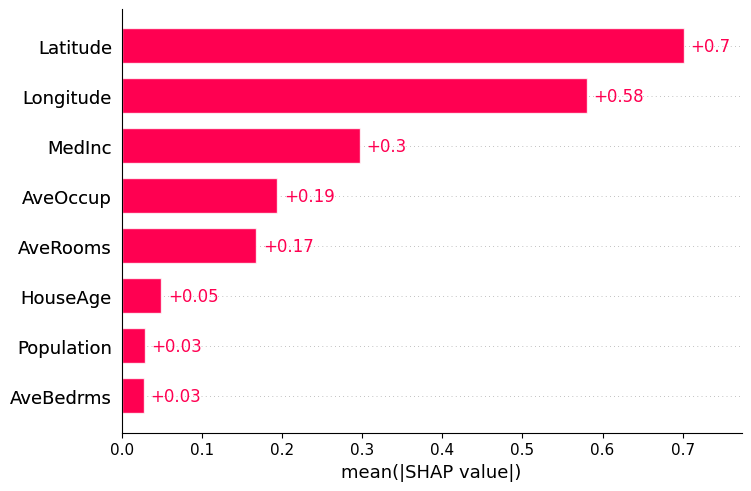

In [31]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [32]:
shap_values.abs.mean(axis=0)

.values =
array([0.2971658 , 0.04948892, 0.1681076 , 0.02806967, 0.02913408,
       0.19430913, 0.70146216, 0.58009819])

.base_values =
np.float64(2.004912161997985)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [33]:
shap_values.abs.mean(axis=0).values

array([0.2971658 , 0.04948892, 0.1681076 , 0.02806967, 0.02913408,
       0.19430913, 0.70146216, 0.58009819])

In [34]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.2971658022511872),
 'HouseAge': np.float64(0.04948892334191908),
 'AveRooms': np.float64(0.16810760401529182),
 'AveBedrms': np.float64(0.028069667015375378),
 'Population': np.float64(0.02913408431140161),
 'AveOccup': np.float64(0.19430912737612138),
 'Latitude': np.float64(0.7014621552192698),
 'Longitude': np.float64(0.5800981867713334)}

In [35]:
feature_importances = {feature:shap_val.item() for feature, shap_val in 
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [36]:
feature_importances

{'MedInc': 0.2971658022511872,
 'HouseAge': 0.04948892334191908,
 'AveRooms': 0.16810760401529182,
 'AveBedrms': 0.028069667015375378,
 'Population': 0.02913408431140161,
 'AveOccup': 0.19430912737612138,
 'Latitude': 0.7014621552192698,
 'Longitude': 0.5800981867713334}

In [37]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'Population',
 'AveBedrms']

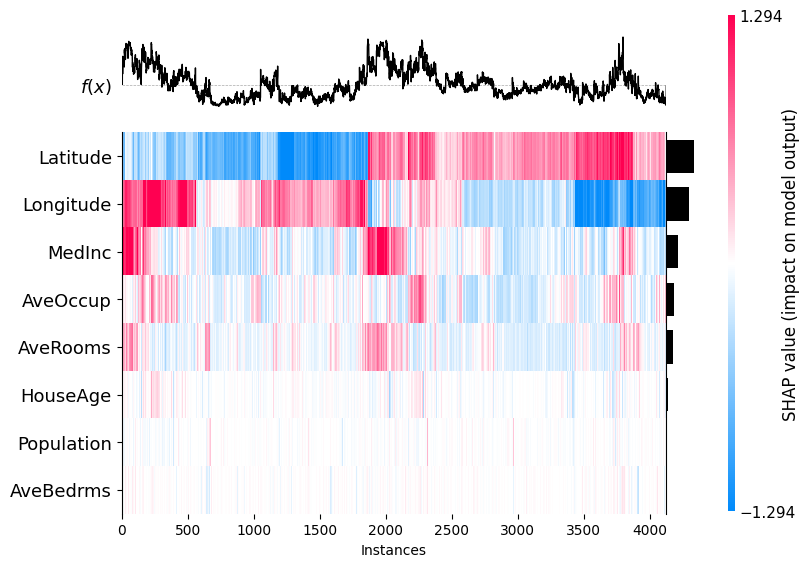

<Axes: xlabel='Instances'>

In [38]:
# heatmap plot

shap.plots.heatmap(shap_values)

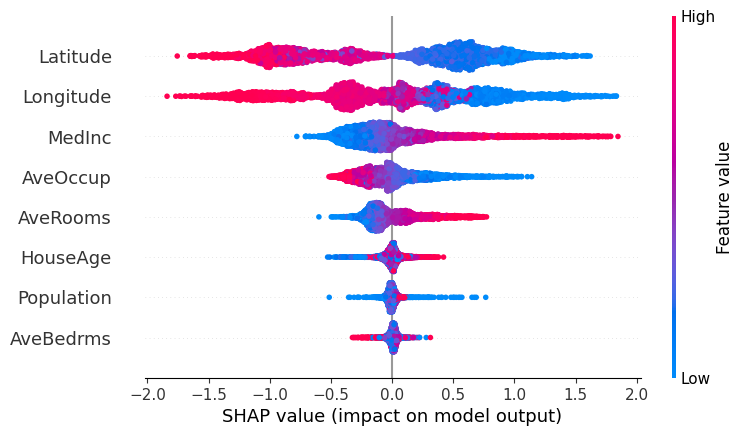

In [40]:
# summary plot

shap.plots.beeswarm(shap_values)

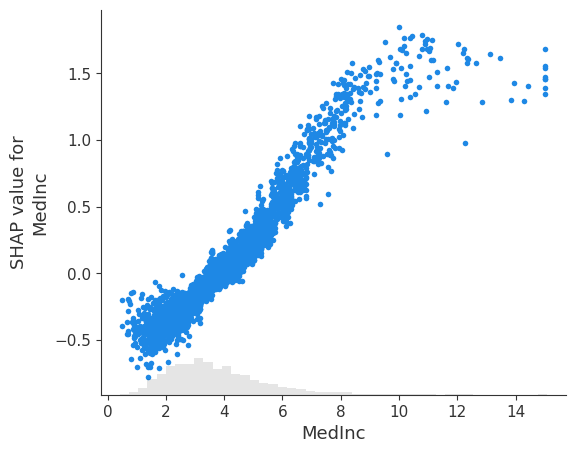

In [42]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

In [52]:
shap_values[:, "Latitude"]

.values =
array([-0.74955068, -0.73855179,  0.0032958 , ..., -0.13814847,
       -1.02897556,  0.24991368], shape=(4128,))

.base_values =
array([2.00491216, 2.00491216, 2.00491216, ..., 2.00491216, 2.00491216,
       2.00491216], shape=(4128,))

.data =
array([36.06, 35.14, 37.8 , ..., 37.31, 36.77, 34.22], shape=(4128,))

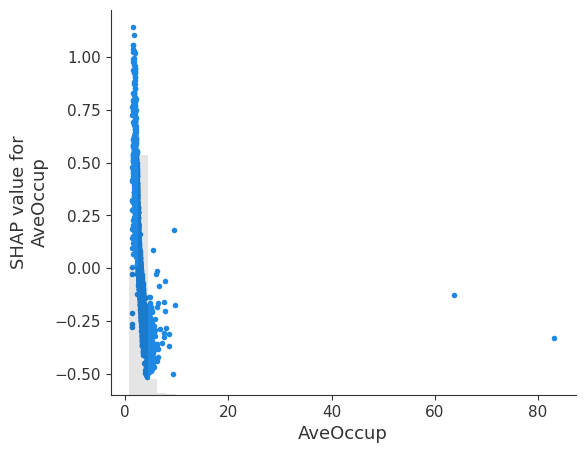

In [43]:
shap.plots.scatter(shap_values[:, "AveOccup"])

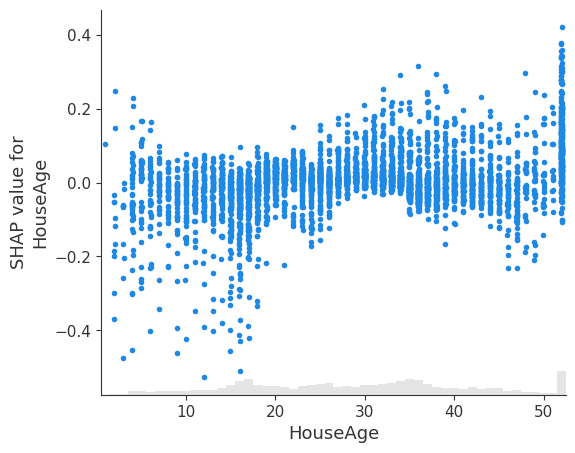

In [44]:
shap.plots.scatter(shap_values[:, "HouseAge"])

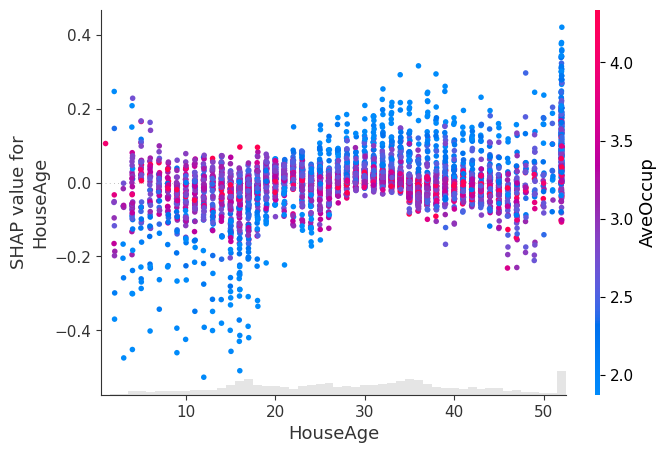

In [45]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

### LOCAL PLOTS

In [53]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20557,2.3468,43.0,4.609547,1.03672,1855.0,2.270502,38.68,-121.78


In [54]:
explained_row = explainer(test_case)

explained_row

.values =
array([[-0.30086491, -0.03440425, -0.14772177,  0.00108203, -0.00456985,
         0.19326479, -1.0778413 ,  0.42494809]])

.base_values =
array([2.00491216])

.data =
array([[ 2.34680000e+00,  4.30000000e+01,  4.60954712e+00,
         1.03671971e+00,  1.85500000e+03,  2.27050184e+00,
         3.86800000e+01, -1.21780000e+02]])

In [58]:
explained_row[0,:].shape

(8,)

In [59]:
explained_row.shape

(1, 8)

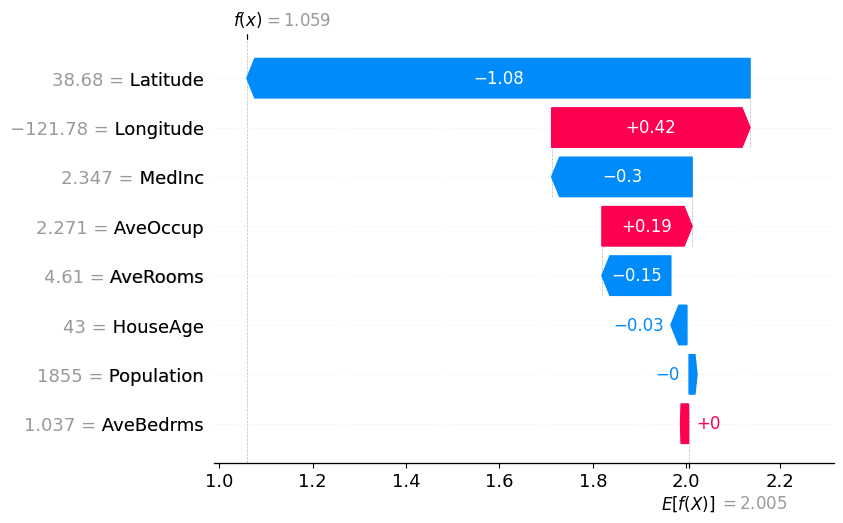

In [61]:
# waterfall plot

shap.plots.waterfall(explained_row[0])

In [49]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

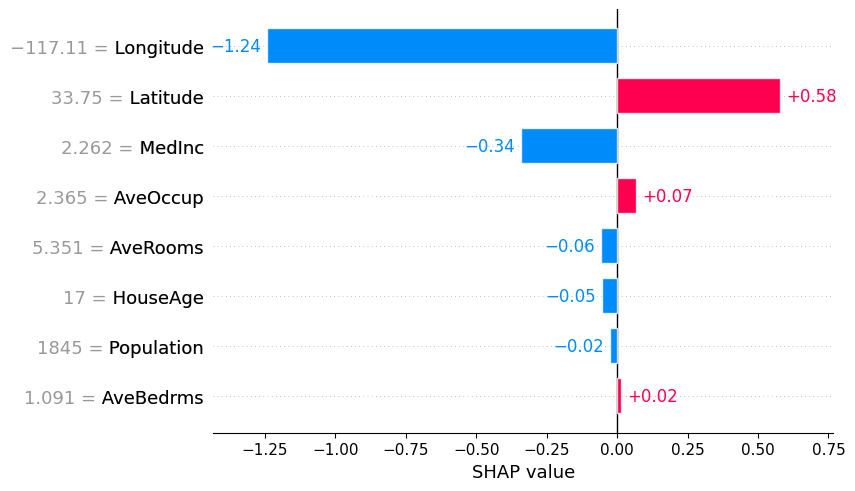

In [50]:
# bar plot for local explaination

shap.plots.bar(explained_row[0])